In [2]:
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 400
df = pd.read_csv("output/result.csv", header=None)
columns = [
              'thread',
              'problem',
              'query',
              'explanation',
              'status',
              'test accuracy',
              'rnn score',
              'LTL explanation score',
              'explanation score on ground truth',
              'LTL extraction time',
              'revised delta',
              'revised epsilon',
              'counterexamples',
              'train size',
              'test size',
              'LTL depth',
            'lstar states',
            'lstar explanation score',
            'lstar explanation score on ground truth',
            'lstar extraction time',
            'lstar status', 
            'epsilon', 
            'delta'
            ,
            'learner time', 
            'verifier time', 
            'random words'
            ]
if(len(df.columns) < len(columns)):
  df.columns = columns[:-3]
else:
  df.columns = columns

# df = df[(df['thread'] <=5 )]
df = df[(df['lstar extraction time']!=0) & (df['epsilon'] == 0.05) & (df['delta'] == 0.05) ]
markersize = 20
fontsize = 32
labelsize = 20



med = df.groupby(['problem','query','epsilon','delta'], as_index=False).mean()[['problem','query','LTL explanation score','lstar explanation score','LTL depth','lstar states', 'LTL extraction time','lstar extraction time','revised epsilon','revised delta','rnn score']]

# med = df[['problem','query','LTL explanation score','lstar explanation score','LTL depth','lstar states', 'LTL extraction time','lstar extraction time','revised epsilon','revised delta','rnn score']]


med['summary explainability'] = med.apply(lambda x : "win" if x['LTL depth'] < x['lstar states'] else ("tie" if x['LTL depth'] == x['lstar states'] else "lose"), axis=1)
med['summary accuracy'] = med.apply(lambda x : "win" if x['LTL explanation score'] > x['lstar explanation score'] else ("tie" if x['LTL explanation score'] == x['lstar explanation score'] else "lose"), axis=1)

med.to_csv("output/average.csv", index=False)




In [3]:
import os
os.system("mkdir output/csv")

dic={"F(a)":"F-a",
     "G(a->X(b))":"G-a-X-b",
     "alternating bit protocol":"abp",
     "balanced parentheses": "bp",
     "email match":"email",
     "F(a & X(b))":"F-a-x-b",
     'G(a)':"G-a"}
for key, item in med.groupby(['problem'], as_index=False):
    item.reset_index(inplace=True)
    item.index += 1
    item.index.names = ['query-no']
    item = item[['LTL explanation score','lstar explanation score','LTL depth','lstar states','LTL extraction time','lstar extraction time']]
    item.columns=["accuracy-LTL",	"accuracy-DFA",	"size-LTL",	"size-DFA",	"time-LTL",	"time-DFA"]
    item.to_csv("output/csv/"+dic[key]+".csv")

    

In [4]:
# for extracting representative rules
replace_dict = dict(zip([
            #    "d",
            "X",
            '|',
            "U",
            "F",
            "G",
            "&",
            "~",
            "->",
            "true",
            "false",
        ], [

            #    "\\\\circ",
            "\\X ",
            "\\vee ",
            "\\U ",
            "\\F ",
            "\\G ",
            " \\wedge ",
            " \\neg ",
            " \\rightarrow",
            "\\top",
            "\\bot",
        ]))

replace_dict_email = dict(zip([
    "X",
    '|',
    "U",
    "F",
    "G",
    "d",
    "&",
    "~",
    "false",
    "a",
    "->",
    "true",
], [
    "\\X ",
    "\\vee ",
    "\\U ",
    "\\F ",
    "\\G ",
    "\\circ ",
    " \\wedge ",
    " \\neg ",
    "\\bot",
    "@",
    " \\rightarrow",
    "\\top",
]))

replace_dict_balanced = dict(zip([
    #    "d",
    "X",
    '|',
    "U",
    "F",
    "G",
    "&",
    "~",
    "->",
    "true",
    "false",
    #    "a"
], [

    #    "\\\\circ",
    "\\X ",
    "\\vee ",
    "\\U ",
    "\\F ",
    "\\G ",
    " \\wedge ",
    " \\neg ",
    " \\rightarrow",
    "\\top",
    "\\bot",
    #    "@"
]))

replace_dict_bit = dict(zip([
    #    "d",
    "b",
    "X",
    '|',
    "U",
    "F",
    "G",
    "~",
    "true",
    "false",
    "a",
    "->",
    "c",
    "d",
    "&",

], [

    #    "\\\\circ",
    "\\text{msg}1",
    "\\X ",
    "\\vee ",
    "\\U ",
    "\\F ",
    "\\G ",
    " \\neg ",
    "\\top",
    "\\bot",
    "\\text{msg}0",
    " \\rightarrow",
    "\\text{ack}0",
    "\\text{ack}1",
    " \\wedge ",

    #    "@"
]))


rules_df = df
# rules_df.groupby(['problem','query'], as_index = False)['explanation'].mode()


problems = rules_df['problem'].unique()
cnt = 0
for problem_ in problems:

    print_once = True
    index = 1
    for key, item in rules_df.groupby(['problem','query'], as_index=False):
        problem, query = key
        if(problem_ != problem):
            continue
        elif(print_once):
            problem_str=''
            if(problem == "email match"):
                problem_str = "Email"
                # print("  ", "Email", "  ")
            elif(problem == "balanced parentheses"):
                # print("  ", "BP", "  ")
                problem_str = "BP"
            elif(problem == "alternating bit protocol"):
                # print("  ", "Bit", "  ")
                problem_str = "Bit"

            else:
                for key in replace_dict.keys():
                    problem = problem.replace(key, replace_dict[key])
                
                problem_str =" $ " + problem + " $ "
                # print(" $ ", problem, " $ ")
            print("""  
            \\begin{table}
            \\caption{Example of LTL explanations of the RNN on""")
            print(problem_str)
            print(""".}""")
            print("\\label{tab:example"+str(cnt)+"}")
            print("""
            
            \\begin{center}
                \\begin{tabular}{p{1.5cm}rp{5 cm}p{5 cm}}
                    \\toprule
                    Problem & No. & Query & Explanation\\\\
                    \\midrule
            """)
            print("  ", problem_str, "  ")

            print_once = False
        # explanation = item['explanation'].mode()[0] # most frequent
        item.reset_index(inplace=True, drop=True)
        explanation = item.iloc[item.index[(item['LTL explanation score']-med['LTL explanation score'][(med['problem']==problem_) & (med['query'] == query)].item()).abs().argsort()][0]]['explanation']
        
        explanation_score = med[(med['problem']==problem_) & (med['query'] == query)]['LTL explanation score'].round(1).item()
        ltl_depth = med[(med['problem']==problem_) & (med['query'] == query)]['LTL depth'].round(1).item()
        extraction_time = med[(med['problem']==problem_) & (med['query'] == query)]['LTL extraction time'].round(2).item()
        if(extraction_time > 400):
            extraction_time = "\\text{\\textemdash}"
        explanation =  explanation[1:-1] if (explanation[0]=="(" and explanation[-1] == ")") else explanation
        lstar_time = med[(med['problem']==problem_) & (med['query'] == query)]['lstar extraction time'].round(2).item()
        lstar_states = med[(med['problem']==problem_) & (med['query'] == query)]['lstar states'].round(1).item()
        lstar_acc = med[(med['problem']==problem_) & (med['query'] == query)]['lstar explanation score'].round(1).item()
        if(lstar_time > 400):
            lstar_time = "\\text{\\textemdash}"

        if(problem == "email match"):
            for key in replace_dict_email.keys():
        
                explanation = explanation.replace(key, replace_dict_email[key])
                query = query.replace(key, replace_dict_email[key])
        elif(problem == "balanced parentheses"):
            for key in replace_dict_balanced.keys():
        
                explanation = explanation.replace(key, replace_dict_balanced[key])
                query = query.replace(key, replace_dict_balanced[key])
        elif(problem == "alternating bit protocol"):
            for key in replace_dict_bit.keys():
        
                explanation = explanation.replace(key, replace_dict_bit[key])
                query = query.replace(key, replace_dict_bit[key])

        else:
            for key in replace_dict.keys():
        
                explanation = explanation.replace(key, replace_dict[key])
                query = query.replace(key, replace_dict[key])

        print('& $', index,"$ & $", query,"$ & $", explanation, "$ \\\\ ")
        # print(ltl_depth)
        # print('& $', query,"$ & $", explanation, "$ & $",ltl_depth, "$ & $", explanation_score, "$ & $", extraction_time, "$ & $", lstar_states, "$ & $", lstar_acc, "$ & $", lstar_time,  "$ \\\\")
        print("\\addlinespace[1em]")
        index +=1
    # if(cnt < len(problems) - 1):
    #     print("\\midrule\n\n\n")
    cnt += 1

    print(""" 
                \\bottomrule
                \\end{tabular}
            \\end{center} """)

    print("\\end{table} ")




            \begin{table}
            \caption{Example of LTL explanations of the RNN on
 $ \G (a) $ 
.}
\label{tab:example0}

            
            \begin{center}
                \begin{tabular}{p{1.5cm}rp{5 cm}p{5 cm}}
                    \toprule
                    Problem & No. & Query & Explanation\\
                    \midrule
            
    $ \G (a) $    
& $ 1 $ & $ \F (a) $ & $ \G  a $ \\ 
\addlinespace[1em]
& $ 2 $ & $ \F (a\U b) $ & $ \bot $ \\ 
\addlinespace[1em]
& $ 3 $ & $ \F (a\vee b) $ & $ \G  a $ \\ 
\addlinespace[1em]
& $ 4 $ & $ \F (b) $ & $ \bot $ \\ 
\addlinespace[1em]
& $ 5 $ & $ \bot $ & $ \bot $ \\ 
\addlinespace[1em]
& $ 6 $ & $ \top $ & $ \G  a $ \\ 
\addlinespace[1em]
 
                \bottomrule
                \end{tabular}
            \end{center} 
\end{table} 


In [5]:
replace_dict = dict(zip([
    "email match",
    "alternating bit protocol",
    'balanced parentheses',
    '&',
    "->",
    'true',
    'false',
    "\|",
    '~'
], [
    'Email',
    'Bit',
    'BP',
    r'$\\wedge$',
    r'$\\rightarrow$',
    r'$\\top$',
    r'$\\bot$',
    r'$\\vee$',
    r'$\\neg$'
]))
med['problem'] = med['problem'].replace(replace_dict, regex=True)
med['query'] = med['query'].replace(replace_dict, regex=True)



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm

# for colors
colors = ['b', 'c', 'y', 'm', 'r','g']

marker = ['x', 'o', "v", '*', 's', "p", 'D', '^']
# line = mlines.Line2D([0, 1], [0, 1], color='black')
# transform = ax.transAxes
# line.set_transform(transform)
# ax.add_line(line)
problems = med['problem'].unique()
index = 0
for problem in problems:
    cnt = 0
    fig, ax = plt.subplots()
    
    for key, item in med.groupby(['problem','query']):

        problem_, query = key
        if(problem == problem_):
            try:
                x = item['LTL explanation score']
                y = item['lstar explanation score']
                ax.scatter(x,y,marker='x', c='black',s=50,label=problem +", "+query)  

     
            except:
                break
            cnt += 1
    print(problem, cnt)
    ax.set_title(problem)
    ax.ticklabel_format(useOffset=False)
    ax.set_xlabel("LTL accuracy")
    ax.set_ylabel("DFA accuracy")
    plt.savefig('output/fig/'+str(index)+'_accuracy_scatter.pdf')
    index += 1

    



G(a) 6


G(a)
         query  LTL explanation score
0         F(a)                  100.0
1       F(aUb)                  100.0
2  F(a$\vee$b)                  100.0
3         F(b)                  100.0
4       $\bot$                  100.0
5       $\top$                  100.0


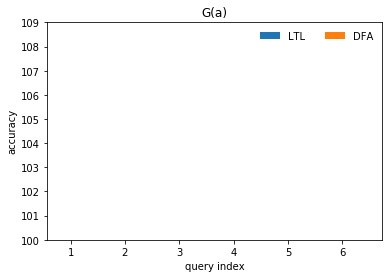

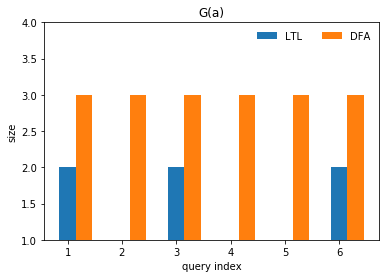

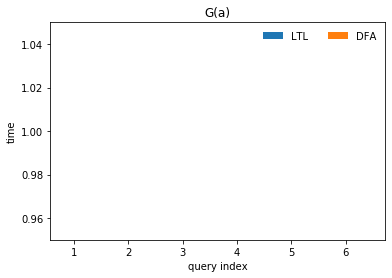

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import math
import os
os.system("mkdir output/fig")
problems = med['problem'].unique()
index = 0
for problem in problems:

    
    ax = plt.subplot(111)
    
    x1 = med[med['problem']==problem]['LTL explanation score'].to_list()
    x2 = med[med['problem']==problem]['lstar explanation score'].to_list()

    print(problem)
    print(med[med['problem']==problem][['query','LTL explanation score']])

    pos = [i+1 for i in range(len(x1))]
    ax.bar(pos,x1,width=0.3,  align='center', label='LTL')
    ax.bar([i+0.3 for i in pos],x2,width=0.3,  align='center', label="DFA")
    ax.set_title(problem)
    ax.set_ylabel("accuracy")
    ax.set_xlabel("query index")
    ax.legend(loc='best',ncol=2, frameon=False)
    low = min([min(x1),min(x2)])
    high = max([max(x1),max(x2)])
    ax.set_ylim([math.ceil(low-0.2*(high-low)), 109])

    ax.set_xticks(pos)
    plt.savefig('output/fig/'+str(index)+'_accuracy_bar.pdf')
    plt.show()
    plt.clf()


    ax = plt.subplot(111)
    
    x1 = med[med['problem']==problem]['LTL depth'].to_list()
    x2 = med[med['problem']==problem]['lstar states'].to_list()
    
    pos = [i+1 for i in range(len(x1))]
    ax.bar(pos,x1,width=0.3,  align='center', label='LTL')
    ax.bar([i+0.3 for i in pos],x2,width=0.3,  align='center', label="DFA")
    ax.set_title(problem)
    ax.set_ylabel("size")
    ax.set_xlabel("query index")
    ax.legend(loc='best',ncol=2, frameon=False)
    low = min([min(x1),min(x2)])
    high = max([max(x1),max(x2)])
    ax.set_ylim([math.ceil(low-0.1*(high-low)), math.ceil(high+0.1*(high-low))])

    ax.set_xticks(pos)
    plt.savefig('output/fig/'+str(index)+'_explanation_bar.pdf')
    plt.show()
    plt.clf()

    ax = plt.subplot(111)
    
    x1 = med[med['problem']==problem]['LTL extraction time'].to_list()
    x2 = med[med['problem']==problem]['lstar extraction time'].to_list()
    
    pos = [i+1 for i in range(len(x1))]
    ax.bar(pos,x1,width=0.3,  align='center', label='LTL')
    ax.bar([i+0.3 for i in pos],x2,width=0.3,  align='center', label="DFA")
    ax.set_title(problem)
    ax.set_ylabel("time")
    ax.set_xlabel("query index")
    ax.legend(loc='best',ncol=2, frameon=False)
    low = min([min(x1),min(x2)])
    high = max([max(x1),max(x2)])
    ax.set_ylim([math.ceil(low-0.1*(high-low)), math.ceil(high+0.1*(high-low))])

    ax.set_xticks(pos)
    plt.savefig('output/fig/'+str(index)+'_time_bar.pdf')
    plt.show()
    plt.clf()




    index += 1
    




G(a) 6


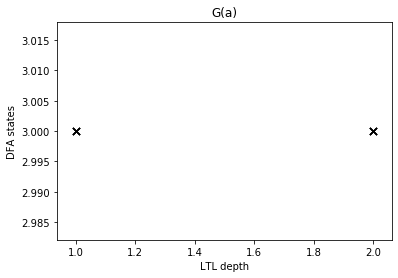

In [7]:


index = 0 
for problem in problems:
    
    cnt = 0
    fig, ax = plt.subplots()
    for key, item in med.groupby(['problem','query']):

        problem_, query = key
        if(problem == problem_):
            try:
                x = item['LTL depth']
                y = item['lstar states']
                ax.scatter(x,y,marker='x', c='black',s=50,label=problem +", "+query)       
                
                
            except:
                break
            cnt += 1
    print(problem, cnt)

    ax.set_title(problem)
    # ax.set_ylim([max(int(min(y))-5,0), int(min(y))+10 + max(int(math.ceil(max(y)))-int(min(y))+2,5)])
    # ax.set_xlim([int(min(x))-1, int(min(x))+max(int(math.ceil(max(x)))-int(min(x))+2,5)])
    ax.set_xlabel("LTL depth")
    ax.set_ylabel("DFA states")
    # plt.legend(loc='best',frameon=True)
    # plt.show()
    plt.savefig('output/fig/'+str(index)+'_explainability_scatter.pdf')
    index += 1

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = np.array([
[0,1,0,2],
[0,3,0,2],
[6,1,1,7],
[0,5,0,2],
])

column_names = ['a','b','c','d']
row_names = ['Mon','Tue','Wed','Thu']

fig = plt.figure()
ax = Axes3D(fig)

lx= len(data[0])            # Work out matrix dimensions
ly= len(data[:,0])
xpos = np.arange(0,lx,1)    # Set up a mesh of positions
ypos = np.arange(0,ly,1)
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()   # Convert positions to 1D array
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'g', 'b', 'y'] * ly

ax.bar3d(xpos,ypos,zpos, dx, dy, dz, color=cs)

#sh()
ax.w_xaxis.set_ticklabels([i for i in range(4)], column_names)
ax.w_yaxis.set_ticklabels(row_names)
ax.set_xlabel('Letter')
ax.set_ylabel('Day')
ax.set_zlabel('Occurrence')

plt.show()

In [8]:
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 400
df = pd.read_csv("output/result.csv", header=None)
columns = ['thread',
              'problem',
              'query',
              'explanation',
              'status',
              'test accuracy',
              'rnn score',
              'LTL explanation score',
              'explanation score on ground truth',
              'LTL extraction time',
              'revised delta',
              'revised epsilon',
              'counterexamples',
              'train size',
              'test size',
              'LTL depth',
            'lstar states',
            'lstar explanation score',
            'lstar explanation score on ground truth',
            'lstar extraction time',
            'lstar status', 
            'epsilon', 
            'delta'
            ,
            'learner time', 
                                          'verifier time', 
            'random words'
              ]
if(len(df.columns) < len(columns)):
  df.columns = columns[:-3]
else:
  df.columns = columns


markersize = 20
fontsize = 32
labelsize = 20





In [9]:
replace_dict = dict(zip([
            #    "d",
            "X",
            '|',
            "U",
            "F",
            "G",
            "&",
            "~",
            "->",
            "true",
            "false",
        ], [

            #    "\\\\circ",
            "_X_",
            "_vee_",
            "_U_",
            "_F_",
            "_G_",
            "_wedge_",
            "_neg_",
            "_rightarrow_",
            "_top_",
            "_bot_",
        ]))
med = df.groupby(['problem','query','epsilon','delta'], as_index=False).mean()[['problem','query','epsilon','delta','LTL explanation score','lstar explanation score','LTL depth','lstar states', 'LTL extraction time','lstar extraction time','revised epsilon','revised delta','rnn score']]
import os 
os.system("mkdir output/fig")

med
   

,problem,query,epsilon,delta,LTL explanation score,lstar explanation score,LTL depth,lstar states,LTL extraction time,lstar extraction time,revised epsilon,revised delta,rnn score
0,G(a),F(a),0.05,0.05,100.0,100.0,2,3,0.833088,0.238054,NaN,NaN,100.0
1,G(a),F(aUb),0.05,0.05,100.0,100.0,1,3,0.213783,0.212322,NaN,NaN,100.0
2,G(a),F(a|b),0.05,0.05,100.0,100.0,2,3,0.839341,0.249863,NaN,NaN,100.0
3,G(a),F(b),0.05,0.05,100.0,100.0,1,3,0.217046,0.214069,NaN,NaN,100.0
4,G(a),false,0.05,0.05,100.0,100.0,1,3,0.212874,0.212264,NaN,NaN,100.0
5,G(a),true,0.05,0.05,100.0,100.0,2,3,0.822605,0.236019,NaN,NaN,100.0


In [10]:
import matplotlib.pyplot as plt

plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

targets = ["F(a)"]
query_ = "true"
fixed_param_values = [0.05, 0.1, 0.25, 0.5]

width = 0.5

show = True


for target in targets:
    for fixed_param_value in fixed_param_values:

        extracted_df=med[(med['problem']==target)]
        

        grouplist=['problem','query','delta']
        for key, item in extracted_df.groupby(grouplist):
            _,query,delta=key
            if(delta != fixed_param_value or query != query_):
                continue
            
            print("\n\n\n")
            print(key)
            
            x_ = 'epsilon'
            
            item = item.sort_values(x_, ascending = True)
            # print(item[[ 'LTL explanation','LTL extraction time', 'LTL explanation score', 'epsilon', 'delta']].to_string(index=False))
            
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.bar([i for i in range(len(item[x_].tolist()))],item['LTL extraction time'], width)
            plt.xticks([i for i in range(len(item[x_].tolist()))],item[x_])
            plt.tick_params(labelsize=labelsize)
            plt.ylabel("time (s)", fontsize=fontsize)
            plt.xlabel(r"$"+"\\"+x_+"$", fontsize=fontsize)
            plt.tight_layout()

            if(query==query_):
                target_name=target
                query_name=query
                for key in replace_dict.keys():
                     target_name= target_name.replace(key, replace_dict[key])
                     query_name= query_name.replace(key, replace_dict[key])
                     
                plt.savefig("output/fig/"+target_name.replace(" ", "_")+"_"+query_name+"_"+x_+"_"+str(int(fixed_param_value*100))+"_time.pdf",bbox_inches='tight')
            if(show):
                plt.show()
            plt.clf()

        grouplist=['problem','query','epsilon']


for target in targets:
    for fixed_param_value in fixed_param_values:

        extracted_df=med[(med['problem']==target)]

        for key, item in extracted_df.groupby(grouplist):
            _,query,epsilon=key
            if(epsilon != fixed_param_value or query != query_):
                continue
            
            print("\n\n\n")
            print(key)

            x_ = 'delta'
            
            item = item.sort_values(x_, ascending = True)
            # print(item[[ 'LTL explanation','LTL extraction time', 'LTL explanation score', 'epsilon', 'delta']].to_string(index=False))
            
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.bar([i for i in range(len(item[x_].tolist()))],item['LTL extraction time'], width)
            plt.xticks([i for i in range(len(item[x_].tolist()))],item[x_])
            plt.tick_params(labelsize=labelsize)
            plt.ylabel("time (s)", fontsize=fontsize)
            plt.xlabel(r"$"+"\\"+x_+"$", fontsize=fontsize)
            plt.tight_layout()
            if(query==query_):
                target_name=target
                query_name=query
                for key in replace_dict.keys():
                     target_name= target_name.replace(key, replace_dict[key])
                     query_name= query_name.replace(key, replace_dict[key])
                     
                plt.savefig("output/fig/"+target_name.replace(" ", "_")+"_"+query_name+"_"+x_+"_"+str(int(fixed_param_value*100))+"_time.pdf",bbox_inches='tight')
            if(show):
                plt.show()
    
            plt.clf()


